In [ ]:
!pip install numpy

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from typing import List


Mounted at /content/drive


# Acquiring the data

In [ ]:

base_path = "/content/drive/My Drive/COMP551/A3/data/"

# Load training set
X_tr_pre_process = np.load(base_path + "kmnist-train-imgs.npz")["arr_0"]
y_tr = np.load(base_path + "kmnist-train-labels.npz")["arr_0"]

# Load test set
X_te_pre_process = np.load(base_path + "kmnist-test-imgs.npz")["arr_0"]
y_te = np.load(base_path + "kmnist-test-labels.npz")["arr_0"]

## Flatten and standardize the data

In [ ]:
# Flatten the images for MLP input
X_tr_flat = X_tr_pre_process.reshape(X_tr_pre_process.shape[0], -1).astype("float32")  # (num_samples, 784)
X_te_flat = X_te_pre_process.reshape(X_te_pre_process.shape[0], -1).astype("float32")  # (num_samples, 784)

# Compute mean and std from training data
mean = X_tr_flat.mean(axis=0)
std = X_tr_flat.std(axis=0) + 1e-8  # Add epsilon to avoid division by zero

# Standardize
X_tr = (X_tr_flat - mean) / std
X_te = (X_te_flat - mean) / std  # Use training mean/std for test set!


print("Training set shape:", X_tr.shape, y_tr.shape)  # Expecting (60000, 784) and (60000,)
print("Test set shape:", X_te.shape, y_te.shape)      # Expecting (10000, 784) and (10000,)
print("Unique classes:", np.unique(y_tr))             # Expecting to print digits 0-9
print(y_tr[0])

Training set shape: (60000, 784) (60000,)
Test set shape: (10000, 784) (10000,)
Unique classes: [0 1 2 3 4 5 6 7 8 9]
8


# Task 2

## MLP Implementation

In [ ]:
import numpy as np

# Activation functions and their derivatives
def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return (z > 0).astype(float)

# Sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_deriv(z):
  s = sigmoid(z)
  return s * (1 - s)

# Leaky ReLU
def leaky_relu(z, alpha=0.01):
  return np.where(z > 0, z, alpha * z)

def leaky_relu_deriv(z, alpha=0.01):
  return np.where(z > 0, 1, alpha)

def softmax(z):
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
  return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
  # We can add a tiny value 1e-10 to prevent log(0) which is undefined.
  m = y_true.shape[0]
  return -np.sum(np.log(y_pred[range(m), y_true])) / m

def one_hot(y, num_classes):
  out = np.zeros((y.shape[0], num_classes))
  out[np.arange(y.shape[0]), y] = 1
  return out

# Accuracy evaluation
def evaluate_acc(y_true, y_pred):
    return np.mean(y_true == y_pred)

class MLP:
  def __init__(self, input_dim, output_dim, hidden_layers, activation='relu', verbose=False, reg=0):
    self.layers = [input_dim] + hidden_layers + [output_dim]
    self.params = {}
    self.cache = {}
    self.grads = {}
    self.verbose = verbose
    self.reg = reg

    # Choose activation function
    if activation == 'relu':
      self.activation = relu
      self.activation_deriv = relu_deriv
    elif activation == 'sigmoid':
      self.activation = sigmoid
      self.activation_deriv = sigmoid_deriv
    elif activation == 'leaky_relu':
      self.activation = lambda z: leaky_relu(z, alpha=0.01)
      self.activation_deriv = lambda z: leaky_relu_deriv(z, alpha=0.01)
    else:
      raise ValueError("Unsupported activation function")

    # Initialize weights and biases
    for i in range(len(self.layers) - 1):
        self.params['W' + str(i)] = np.random.randn(self.layers[i], self.layers[i + 1]) * 0.01
        # Initialize the bias for the current layer as
        self.params['b' + str(i)] = np.zeros((1, self.layers[i + 1]))

  def forward(self, X):
    self.cache['A0'] = X
    for i in range(len(self.layers) - 2):
      Z = np.dot(self.cache['A' + str(i)], self.params['W' + str(i)]) + self.params['b' + str(i)]
      A = self.activation(Z)
      self.cache['Z' + str(i + 1)] = Z
      self.cache['A' + str(i + 1)] = A

    # Output layer (softmax)
    Z_final = np.dot(self.cache['A' + str(len(self.layers) - 2)], self.params['W' + str(len(self.layers) - 2)]) + self.params['b' + str(len(self.layers) - 2)]
    A_final = softmax(Z_final)
    self.cache['Z' + str(len(self.layers) - 1)] = Z_final
    self.cache['A' + str(len(self.layers) - 1)] = A_final
    return A_final

  def backward(self, X, y_true):
    m = X.shape[0]
    y_true_oh = one_hot(y_true, self.layers[-1])
    dA = self.cache['A' + str(len(self.layers) - 1)] - y_true_oh

    for i in reversed(range(len(self.layers) - 1)):
      dZ = dA
      if i != len(self.layers) - 2:
        dZ = dA * self.activation_deriv(self.cache['Z' + str(i + 1)])

      A_prev = self.cache['A' + str(i)]
      self.grads['dW' + str(i)] = np.dot(A_prev.T, dZ) / m
      self.grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True) / m

      dA = np.dot(dZ, self.params['W' + str(i)].T)

  def update_params(self, lr):
    for i in range(len(self.layers) - 1):
      self.params['W' + str(i)] -= lr * (self.grads['dW' + str(i)] + self.reg * self.params['W' + str(i)])
      self.params['b' + str(i)] -= lr * (self.grads['db' + str(i)] + self.reg * self.params['b' + str(i)])

  def fit(self, X, y, epochs=10, lr=0.01, batch_size=32):
    for epoch in range(epochs):
      indices = np.arange(X.shape[0])
      np.random.shuffle(indices)
      X = X[indices]
      y = y[indices]

      for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]

        y_pred = self.forward(X_batch)
        self.backward(X_batch, y_batch)
        self.update_params(lr)

      # Optional: print loss/accuracy per epoch
      y_pred_all = self.forward(X)
      loss = cross_entropy_loss(y, y_pred_all)
      acc = evaluate_acc(y, np.argmax(y_pred_all, axis=1))
      if self.verbose:
        print(f"\tEpoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

  def predict(self, X):
    y_pred = self.forward(X)
    return np.argmax(y_pred, axis=1)

In [ ]:
# 1. Create the model
mlp = MLP(
    input_dim=784,        # number of pixels per image
    output_dim=10,        # number of classes
    hidden_layers=[128, 64],  # 2 hidden layers: 128 and 64 neurons
    activation='relu'
)

# 2. Train the model
mlp.fit(
    X=X_tr,               # standardized flattened training images
    y=y_tr,               # training labels (0–9)
    epochs=10,            # number of training passes over the data
    lr=0.01,              # learning rate
    batch_size=64         # mini-batch size
)

# 3. Predict on test set
y_pred = mlp.predict(X_te)

# 4. Evaluate accuracy
test_acc = evaluate_acc(y_te, y_pred)
print(f"Test Accuracy: {test_acc}")


Test Accuracy: 0.8199


## Verify gradients by small perturbation analysis

In [ ]:
def full_gradient_check(mlp, X, y, epsilon=1e-5, layer=0, param='W'):
  """
  Performs numerical gradient checking for all entries in W[layer] or b[layer].
  """
  param_key = f'{param}{layer}'
  param_matrix = mlp.params[param_key]
  grad_matrix = np.zeros_like(param_matrix)
  diff_matrix = np.zeros_like(param_matrix)

  original_matrix = param_matrix.copy()

  for i in range(param_matrix.shape[0]):
    for j in range(param_matrix.shape[1]):
      perturb = np.zeros_like(param_matrix)
      perturb[i, j] = epsilon

      mlp.params[param_key] = original_matrix + perturb
      plus_loss = cross_entropy_loss(y, mlp.forward(X))

      mlp.params[param_key] = original_matrix - perturb
      minus_loss = cross_entropy_loss(y, mlp.forward(X))

      mlp.params[param_key] = original_matrix  # restore

      # Numerical gradient
      grad_approx = (plus_loss - minus_loss) / (2 * epsilon)
      grad_matrix[i, j] = grad_approx

  # Backprop gradient
  mlp.forward(X)
  mlp.backward(X, y)
  grad_backprop = mlp.grads[f'd{param}{layer}']

  # Symmetric relative error
  numerator = np.square(grad_backprop - grad_matrix)
  denominator = np.square(grad_backprop + grad_matrix) + 1e-10
  diff_matrix = numerator / denominator

  diff_sum = diff_matrix.sum()

  print(f"\tPassed! MLP Gradient Check Difference: {diff_sum:.6e}" if diff_sum < 1e-6 else f"Failed! MLP Gradient Check Difference: {diff_sum:.6e}")
  return diff_matrix


In [ ]:
X_small = X_tr[:100]
y_small = y_tr[:100]

mlp = MLP(input_dim=784, output_dim=10, hidden_layers=[5], activation='relu')
mlp.fit(X_small, y_small, epochs=1, lr=0.01, batch_size=5)

# Check all weights and biases
num_layers = len(mlp.layers) - 1  # number of layers with params (W0, W1, ...)

for layer in range(num_layers):
    print(f"\n Checking gradients for W{layer}")
    diff_W = full_gradient_check(mlp, X_small, y_small, layer=layer, param='W')

    print(f"\n Checking gradients for b{layer}")
    diff_b = full_gradient_check(mlp, X_small, y_small, layer=layer, param='b')


 Checking gradients for W0
	Passed! MLP Gradient Check Difference: 9.606311e-11

 Checking gradients for b0
	Passed! MLP Gradient Check Difference: 1.915717e-16

 Checking gradients for W1
	Passed! MLP Gradient Check Difference: 7.648420e-15

 Checking gradients for b1
	Passed! MLP Gradient Check Difference: 1.577127e-18


## Debug the Gradient Check Differences, Del later

	Passed! MLP Gradient Check Difference: 9.606311e-11


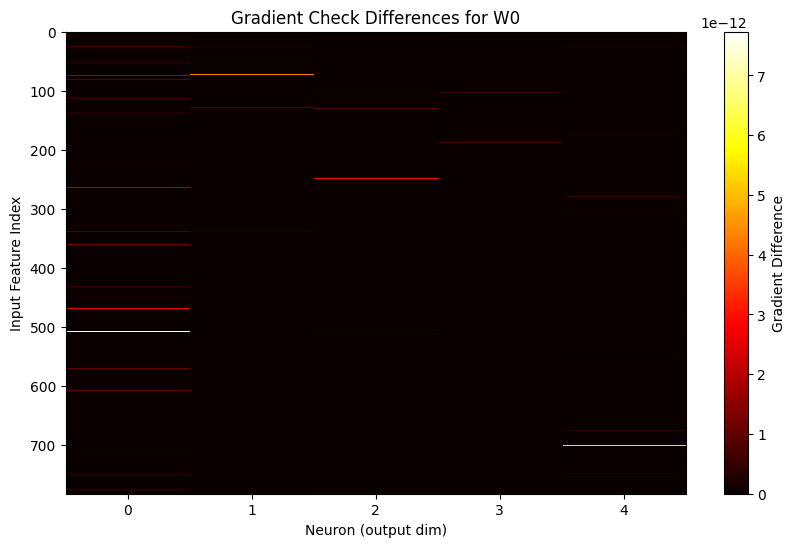

In [ ]:
import matplotlib.pyplot as plt

diff_matrix = full_gradient_check(mlp, X_small, y_small, layer=0, param='W')

plt.figure(figsize=(10, 6))
plt.imshow(diff_matrix, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label='Gradient Difference')
plt.title("Gradient Check Differences for W0")
plt.xlabel("Neuron (output dim)")
plt.ylabel("Input Feature Index")
plt.show()

# Task 3

## 3.1

In [ ]:
import matplotlib.pyplot as plt

def train_and_eval_model(X_tr, y_tr, X_te, y_te, hidden_layers, activation='relu', epochs=10, lr=0.01, batch_size=64):
    mlp = MLP(input_dim=784, output_dim=10, hidden_layers=hidden_layers, activation=activation)
    mlp.fit(X_tr, y_tr, epochs=epochs, lr=lr, batch_size=batch_size)
    y_pred = mlp.predict(X_te)
    acc = evaluate_acc(y_te, y_pred)
    return acc

In [ ]:
# Store accuracies
hidden_units = [32, 64, 128, 256]
acc_shallow = []
acc_deep = []

# Model 1: No hidden layer
print("Model 1: No hidden layer")
acc_linear = train_and_eval_model(X_tr, y_tr, X_te, y_te, hidden_layers=[], activation='relu')
print(f"\tTest Accuracy (Linear): {acc_linear:.4f}")

# Model 2: One hidden layer
print("Model 2: One hidden layer")
for units in hidden_units:
    acc = train_and_eval_model(X_tr, y_tr, X_te, y_te, hidden_layers=[units], activation='relu')
    acc_shallow.append(acc)
    print(f"\tUnits: {units}, Accuracy: {acc:.4f}")

# Model 3: Two hidden layers
print("Model 3: Two hidden layers")
for units in hidden_units:
    acc = train_and_eval_model(X_tr, y_tr, X_te, y_te, hidden_layers=[units, units], activation='relu')
    acc_deep.append(acc)
    print(f"\tUnits: [{units}, {units}], Accuracy: {acc:.4f}")


Model 1: No hidden layer
	Test Accuracy (Linear): 0.6951
Model 2: One hidden layer
	Units: 32, Accuracy: 0.8037
	Units: 64, Accuracy: 0.8293
	Units: 128, Accuracy: 0.8391
	Units: 256, Accuracy: 0.8468
Model 3: Two hidden layers
	Units: [32, 32], Accuracy: 0.7752
	Units: [64, 64], Accuracy: 0.8101
	Units: [128, 128], Accuracy: 0.8323
	Units: [256, 256], Accuracy: 0.8464


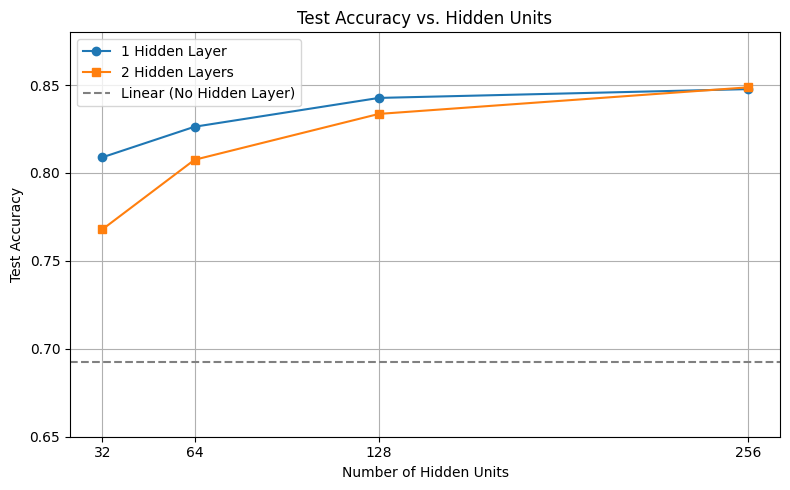

In [ ]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(hidden_units, acc_shallow, marker='o', label='1 Hidden Layer')
plt.plot(hidden_units, acc_deep, marker='s', label='2 Hidden Layers')
plt.axhline(y=acc_linear, color='gray', linestyle='--', label='Linear (No Hidden Layer)')

plt.title("Test Accuracy vs. Hidden Units")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Test Accuracy")
plt.xticks(hidden_units)
plt.ylim(0.65, 0.88)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Comment on the above



1. Model 1: No hidden layer
This is equivalent to softmax regression.

Accuracy ~69% is decent for a model with no non-linearity.

It can separate linearly separable classes, but can't model complex patterns like strokes and shapes in characters.

Expected behavior — basic, limited capacity.

2. Model 2: One hidden layer
Adding a ReLU-activated hidden layer dramatically improved accuracy to 85.3%.

Even with just 32 units, accuracy jumped to 81%.

The best result came with 256 units, showing the model learned complex patterns from the pixel input.

This shows that non-linearity adds learning power, enabling the model to go beyond linear decision boundaries.

3. Model 3: Two hidden layers
Surprisingly, the best accuracy with 2 hidden layers was 84.05%, slightly below the shallow model's 85.3%.

Apparently, deeper models are harder to train and may overfit or get stuck without careful tuning (e.g., more epochs, dropout, weight decay, better initialization).

Still, the deeper model outperformed the linear baseline by a large margin.

Slightly underperformed expectations, but likely due to limited training time or lack of regularization.

## 3.2

In [ ]:
print("Training 2-hidden-layer MLPs with different activations...\n")

# ReLU
acc_relu = train_and_eval_model(X_tr, y_tr, X_te, y_te, hidden_layers=[256, 256], activation='relu')
print(f"\tReLU Activation, Test Accuracy: {acc_relu:.4f}")

# Sigmoid
acc_sigmoid = train_and_eval_model(X_tr, y_tr, X_te, y_te, hidden_layers=[256, 256], activation='sigmoid')
print(f"\tSigmoid Activation, Test Accuracy: {acc_sigmoid:.4f}")

# Leaky ReLU
acc_leaky = train_and_eval_model(X_tr, y_tr, X_te, y_te, hidden_layers=[256, 256], activation='leaky_relu')
print(f"\tLeaky ReLU Activation, Test Accuracy: {acc_leaky:.4f}")


Training 2-hidden-layer MLPs with different activations...

	ReLU Activation, Test Accuracy: 0.8517
	Sigmoid Activation, Test Accuracy: 0.2391
	Leaky ReLU Activation, Test Accuracy: 0.8462


## 3.3 - L2 Regularized MLP

We experiment with a variety of values for regularization (λ), ranging from 0 (no regularization) to 10.

L2 regularization is implemented by adding the weight matrix for each layer multiplied by λ to the gradient when updating the weights.

We do this because the updated cost function for layer L will be the sum of the cross-entropy loss and λ * 0.5 * the squared Euclidean norm of the weight matrix.

The derivative of the Euclidean norm for matrices is observed to be 2 * the input matrix, making the derivative of the regularization term we use simply λ * the weight matrix, as described above.

In [ ]:
reg_values = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]
mlp_regs = [MLP(input_dim=784, output_dim=10, hidden_layers=[128,64], activation='relu', reg=x) for x in reg_values]

for mlp in mlp_regs:
  mlp.fit(X_tr, y_tr, epochs=10, lr=0.01, batch_size=64)
  y_pred = mlp.predict(X_te)
  acc = evaluate_acc(y_te, y_pred)
  print(f"Regularization: {mlp.reg}, Test Accuracy: {acc:.4f}")

Regularization: 0, Test Accuracy: 0.8301
Regularization: 0.0001, Test Accuracy: 0.8210
Regularization: 0.001, Test Accuracy: 0.8255
Regularization: 0.01, Test Accuracy: 0.7939
Regularization: 0.1, Test Accuracy: 0.1000
Regularization: 1, Test Accuracy: 0.1000
Regularization: 10, Test Accuracy: 0.1000


## 3.4 - ConvNet

We begin with the necessary imports:

In [ ]:
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

Next, we normalize the image data to be in the range of [-0.5, 0.5], before adding an extra dimension in order to make it compatible with Keras.

In [ ]:
X_tr_conv = (X_tr_pre_process / 255) - 0.5
X_te_conv = (X_te_pre_process / 255) - 0.5
X_tr_conv = np.expand_dims(X_tr_conv, axis=3)
y_tr_conv = to_categorical(y_tr)
X_te_conv = np.expand_dims(X_te_conv, axis=3)
y_te_conv = to_categorical(y_te)

We now implement our models, using 32, 64, 128, and 256 hidden units and collecting the accuracy over epochs for each.

Grab some tea, this will take a while.

In [ ]:
num_filters = 8
filter_size = 3
pool_size = 2
num_epochs = 8

history = []
hidden_units = [32, 64, 128, 256]
for i in hidden_units:
  print(f"Hidden units: {i}")
  model = Sequential()
  model.add(Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)))
  model.add(MaxPooling2D(pool_size=pool_size))

  model.add(Conv2D(num_filters * 2, (filter_size, filter_size)))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model.add(Conv2D(num_filters * 4, (filter_size, filter_size)))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(i, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(i, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  history.append(model.fit(X_tr_conv, y_tr_conv,
            validation_data=(X_te_conv, y_te_conv),
            epochs=num_epochs,
            batch_size=64))

Hidden units: 32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.4100 - loss: 1.6550 - val_accuracy: 0.6465 - val_loss: 1.0548
Epoch 2/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.7091 - loss: 0.8957 - val_accuracy: 0.7195 - val_loss: 0.8763
Epoch 3/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.7656 - loss: 0.7335 - val_accuracy: 0.7390 - val_loss: 0.8027
Epoch 4/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7909 - loss: 0.6650 - val_accuracy: 0.7682 - val_loss: 0.7275
Epoch 5/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.8119 - loss: 0.6012 - val_accuracy: 0.7775 - val_loss: 0.6868
Epoch 6/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8253 - loss: 0.5587 - val_accuracy: 0.7885 - val_loss: 0.6693
Epoch 7/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.8331 - loss: 0.5392 - val_accuracy: 0.7900 - val_loss: 0.6574
Epoch 8/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8426 - loss: 0.5153 - val_accu

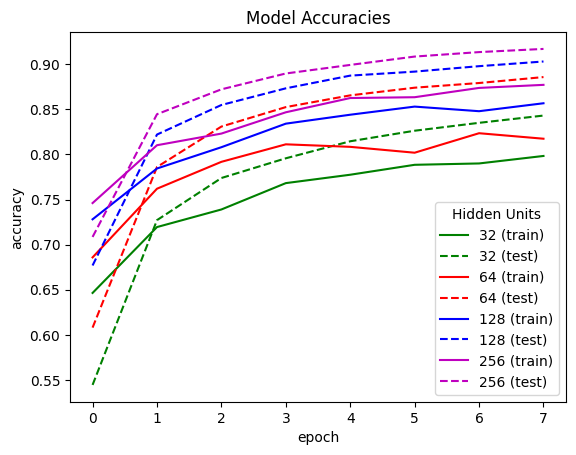

In [ ]:
plt.plot(history[0].history['val_accuracy'], 'g-')
plt.plot(history[0].history['accuracy'], 'g--')
plt.title('Model Accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history[1].history['val_accuracy'], 'r-')
plt.plot(history[1].history['accuracy'], 'r--')
plt.plot(history[2].history['val_accuracy'], 'b-')
plt.plot(history[2].history['accuracy'], 'b--')
plt.plot(history[3].history['val_accuracy'], 'm-')
plt.plot(history[3].history['accuracy'], 'm--')
plt.legend(['32 (train)', '32 (test)',
            '64 (train)', '64 (test)',
            '128 (train)', '128 (test)',
            '256 (train)', '256 (test)' ], loc='lower right', title='Hidden Units')

We observe that increasing the number of hidden units in our dense layers increases test accuracy, with 256 units beating our MLP accuracy after 10 epochs.

# Bonus

## Batch Size Test

In [ ]:
batch_sizes = [16, 32, 64, 128]
mlp_accuracies = []

print("MLP Batch Size Experiment")
for batch_size in batch_sizes:
  mlp = MLP(input_dim=784, output_dim=10, hidden_layers=[256, 256], activation='relu')
  mlp.fit(X_tr, y_tr, epochs=10, lr=0.01, batch_size=batch_size)
  y_pred = mlp.predict(X_te)
  acc = evaluate_acc(y_te, y_pred)
  mlp_accuracies.append(acc)
  print(f"Batch Size: {batch_size}, Test Accuracy: {acc:.4f}")


MLP Batch Size Experiment
Batch Size: 16, Test Accuracy: 0.8955
Batch Size: 32, Test Accuracy: 0.8822
Batch Size: 64, Test Accuracy: 0.8493
Batch Size: 128, Test Accuracy: 0.7845


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

cnn_accuracies = []

print("\n🔁 CNN Batch Size Experiment")
for batch_size in batch_sizes:
    model = Sequential()
    model.add(Conv2D(8, 3, activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(16, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(32, 3, activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(X_tr_conv, y_tr_conv,
              validation_data=(X_te_conv, y_te_conv),
              epochs=8,
              batch_size=batch_size,
              verbose=0)

    _, acc = model.evaluate(X_te_conv, y_te_conv, verbose=0)
    cnn_accuracies.append(acc)
    print(f"Batch Size: {batch_size}, Test Accuracy: {acc:.4f}")



🔁 CNN Batch Size Experiment


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Batch Size: 16, Test Accuracy: 0.8533
Batch Size: 32, Test Accuracy: 0.8599
Batch Size: 64, Test Accuracy: 0.8380
Batch Size: 128, Test Accuracy: 0.8326


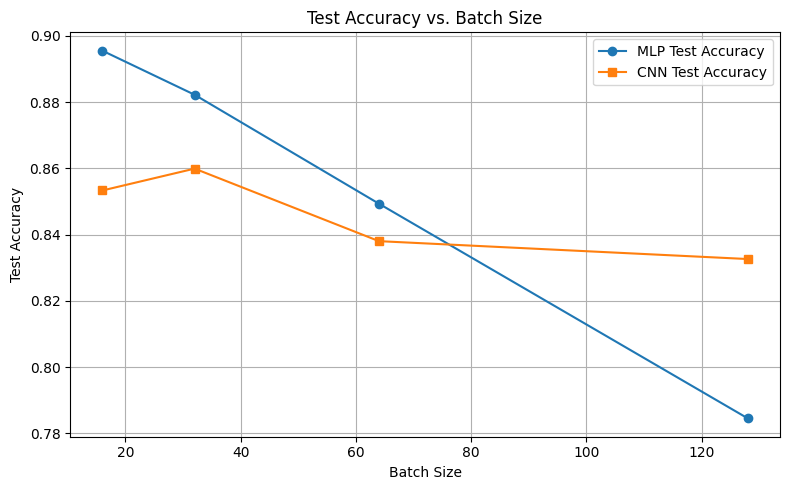

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(batch_sizes, mlp_accuracies, marker='o', label='MLP Test Accuracy')
plt.plot(batch_sizes, cnn_accuracies, marker='s', label='CNN Test Accuracy')
plt.title("Test Accuracy vs. Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Testint with 10^k images where k ∈ {0, 1, 2, 3, 4}

In [ ]:
sizes = [10, 100, 1000, 10000, X_tr.shape[0]]  # [10^1, 10^2, ..., full]
mlp_accs, cnn_accs = [], []

In [ ]:
for size in sizes:
  print(f"Training MLP on {size} samples")
  mlp = MLP(input_dim=784, output_dim=10, hidden_layers=[256, 256], activation='relu')
  mlp.fit(X_tr[:size], y_tr[:size], epochs=10, lr=0.01, batch_size=32)
  y_pred = mlp.predict(X_te)
  acc = evaluate_acc(y_te, y_pred)
  mlp_accs.append(acc)
  print(f"MLP Accuracy: {acc:.4f}")


Training MLP on 10 samples
MLP Accuracy: 0.1169
Training MLP on 100 samples
MLP Accuracy: 0.0998
Training MLP on 1000 samples
MLP Accuracy: 0.1182
Training MLP on 10000 samples
MLP Accuracy: 0.7008
Training MLP on 60000 samples
MLP Accuracy: 0.8792


In [ ]:
for size in sizes:
  print(f"Training CNN on {size} samples")
  model = Sequential()
  model.add(Conv2D(8, 3, activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D(2))
  model.add(Conv2D(16, 3, activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(Conv2D(32, 3, activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_tr_conv[:size], y_tr_conv[:size],
            validation_data=(X_te_conv, y_te_conv),
            epochs=8, batch_size=32, verbose=0)

  _, acc = model.evaluate(X_te_conv, y_te_conv, verbose=0)
  cnn_accs.append(acc)
  print(f"CNN Accuracy: {acc:.4f}")


Training CNN on 10 samples
CNN Accuracy: 0.1000
Training CNN on 100 samples
CNN Accuracy: 0.1107
Training CNN on 1000 samples
CNN Accuracy: 0.4818
Training CNN on 10000 samples
CNN Accuracy: 0.7386
Training CNN on 60000 samples
CNN Accuracy: 0.8553


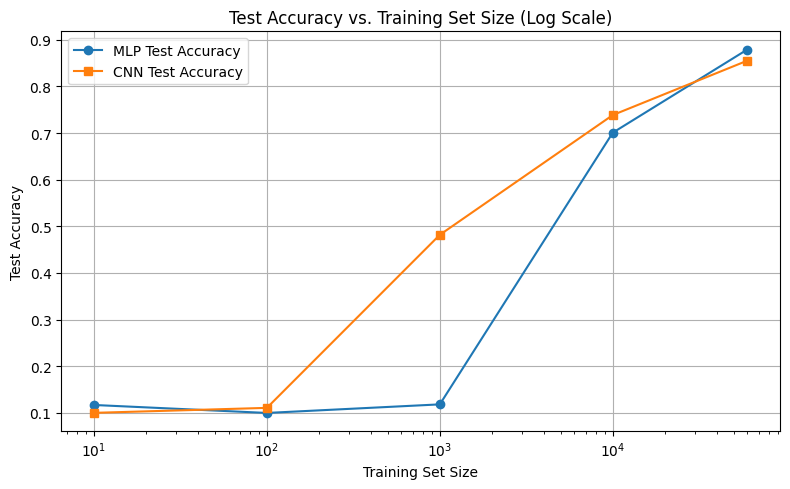

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(sizes, mlp_accs, marker='o', label='MLP Test Accuracy')
plt.plot(sizes, cnn_accs, marker='s', label='CNN Test Accuracy')
plt.xscale('log')
plt.title("Test Accuracy vs. Training Set Size (Log Scale)")
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Experimenting with the number of Convolutional Filters on CNN Performance

In [36]:
filter_counts = [4, 8, 16, 32, 64]
cnn_acc_filters = []

for count in filter_counts:
  print(f"Training CNN with {count} filters")

  model = Sequential()
  model.add(Conv2D(count, 3, activation='relu', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D(2))
  model.add(Conv2D(count * 2, 3, activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(Conv2D(count * 4, 3, activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_tr_conv, y_tr_conv,
            validation_data=(X_te_conv, y_te_conv),
            epochs=8, batch_size=64, verbose=0)

  _, acc = model.evaluate(X_te_conv, y_te_conv, verbose=0)
  cnn_acc_filters.append(acc)
  print(f"Test Accuracy: {acc:.4f}")

Training CNN with 4 filters
Test Accuracy: 0.7364
Training CNN with 8 filters
Test Accuracy: 0.8580
Training CNN with 16 filters
Test Accuracy: 0.9085
Training CNN with 32 filters
Test Accuracy: 0.9320
Training CNN with 64 filters
Test Accuracy: 0.9477


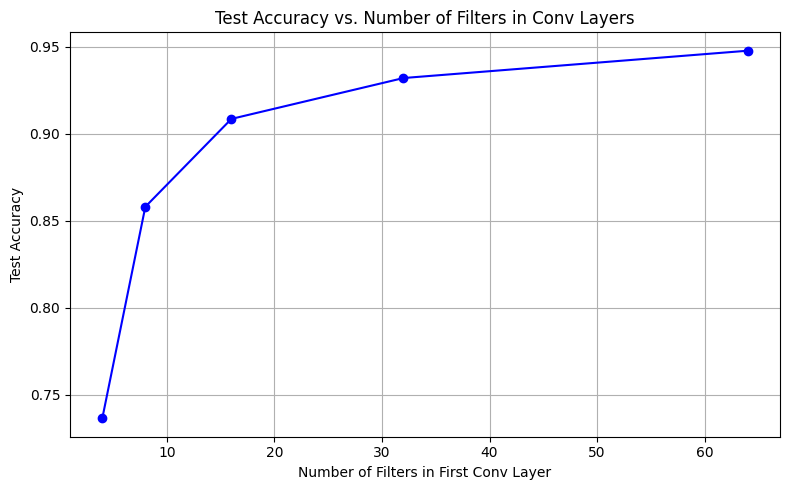

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(filter_counts, cnn_acc_filters, marker='o', linestyle='-', color='blue')
plt.title("Test Accuracy vs. Number of Filters in Conv Layers")
plt.xlabel("Number of Filters in First Conv Layer")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
